### Step 1: Data Collection and Understanding

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import io


In [2]:
# Set up data directories
train_dir = "chest_xray/train"
val_dir = "chest_xray/val"
test_dir = "chest_xray/test"

In [3]:
# Count images in each split
def count_images(directory):
    normal = len(os.listdir(os.path.join(directory, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(directory, "PNEUMONIA")))
    return normal, pneumonia


In [4]:
train_normal, train_pneumonia = count_images(train_dir)
val_normal, val_pneumonia = count_images(val_dir)
test_normal, test_pneumonia = count_images(test_dir)

print(f"Training: {train_normal} normal, {train_pneumonia} pneumonia")
print(f"Validation: {val_normal} normal, {val_pneumonia} pneumonia")
print(f"Testing: {test_normal} normal, {test_pneumonia} pneumonia")

Training: 1341 normal, 3875 pneumonia
Validation: 8 normal, 8 pneumonia
Testing: 234 normal, 390 pneumonia


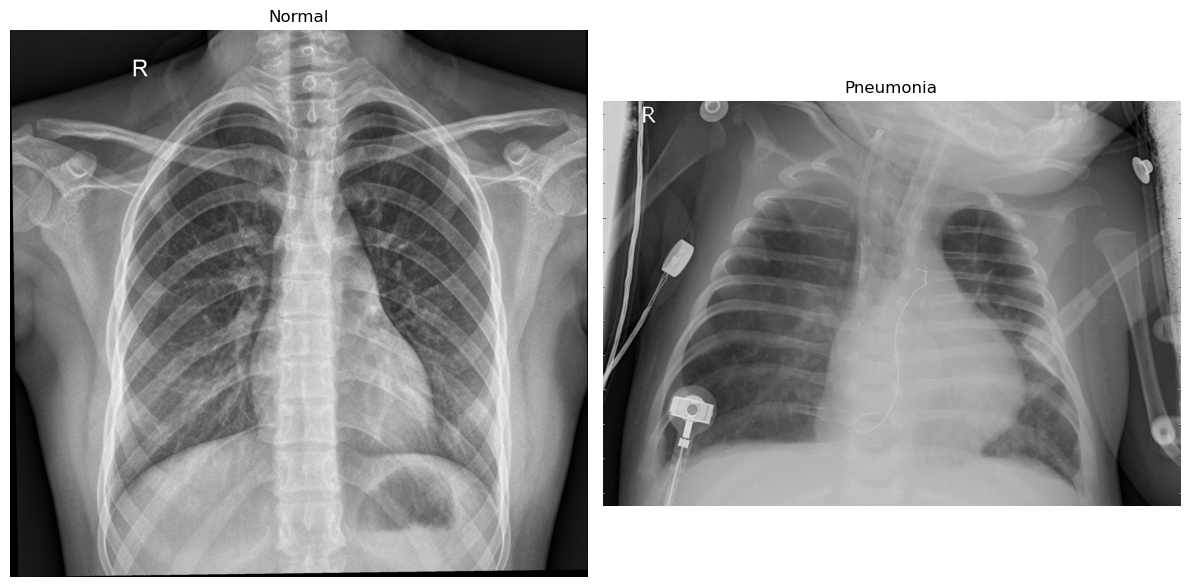

In [5]:
# Visualize sample images
def visualize_sample_images():
    plt.figure(figsize=(12, 6))
    
    # Normal image
    normal_img_path = os.path.join(train_dir, "NORMAL", os.listdir(os.path.join(train_dir, "NORMAL"))[0])
    normal_img = Image.open(normal_img_path).convert("L")  # Convert to grayscale
    
    # Pneumonia image
    pneumonia_img_path = os.path.join(train_dir, "PNEUMONIA", os.listdir(os.path.join(train_dir, "PNEUMONIA"))[0])
    pneumonia_img = Image.open(pneumonia_img_path).convert("L")  # Convert to grayscale
    
    plt.subplot(1, 2, 1)
    plt.imshow(normal_img, cmap='gray')
    plt.title("Normal")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(pneumonia_img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_sample_images()

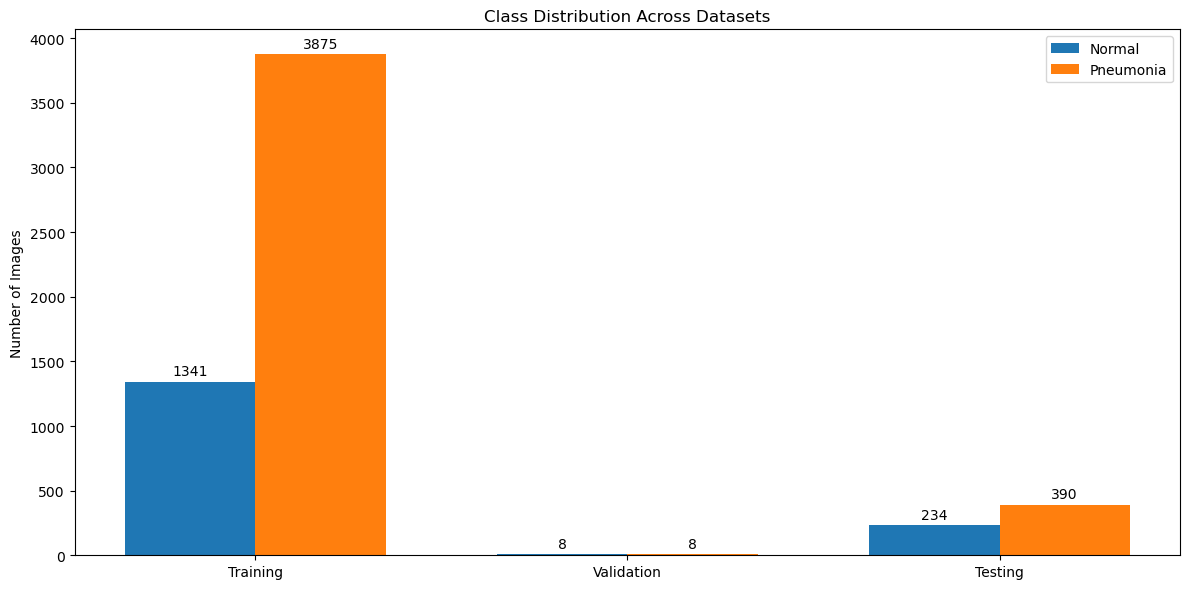

In [6]:
# Visualize class distribution
def visualize_class_distribution():
    categories = ['Training', 'Validation', 'Testing']
    normal_counts = [train_normal, val_normal, test_normal]
    pneumonia_counts = [train_pneumonia, val_pneumonia, test_pneumonia]
    
    x = np.arange(len(categories))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, normal_counts, width, label='Normal')
    ax.bar(x + width/2, pneumonia_counts, width, label='Pneumonia')
    
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    ax.set_ylabel('Number of Images')
    ax.set_title('Class Distribution Across Datasets')
    
    for i, count in enumerate(normal_counts):
        ax.text(i - width/2, count + 50, str(count), ha='center')
    
    for i, count in enumerate(pneumonia_counts):
        ax.text(i + width/2, count + 50, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()

visualize_class_distribution()

##### We can see that the dataset is imbalanced in training. So we will use class weights to balance it.

### Step 2: Data Preprocessing

In [7]:
# Define image size
IMG_SIZE = 224  # Standard size for many pre-trained CNN models

In [8]:
# Create data generators with preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


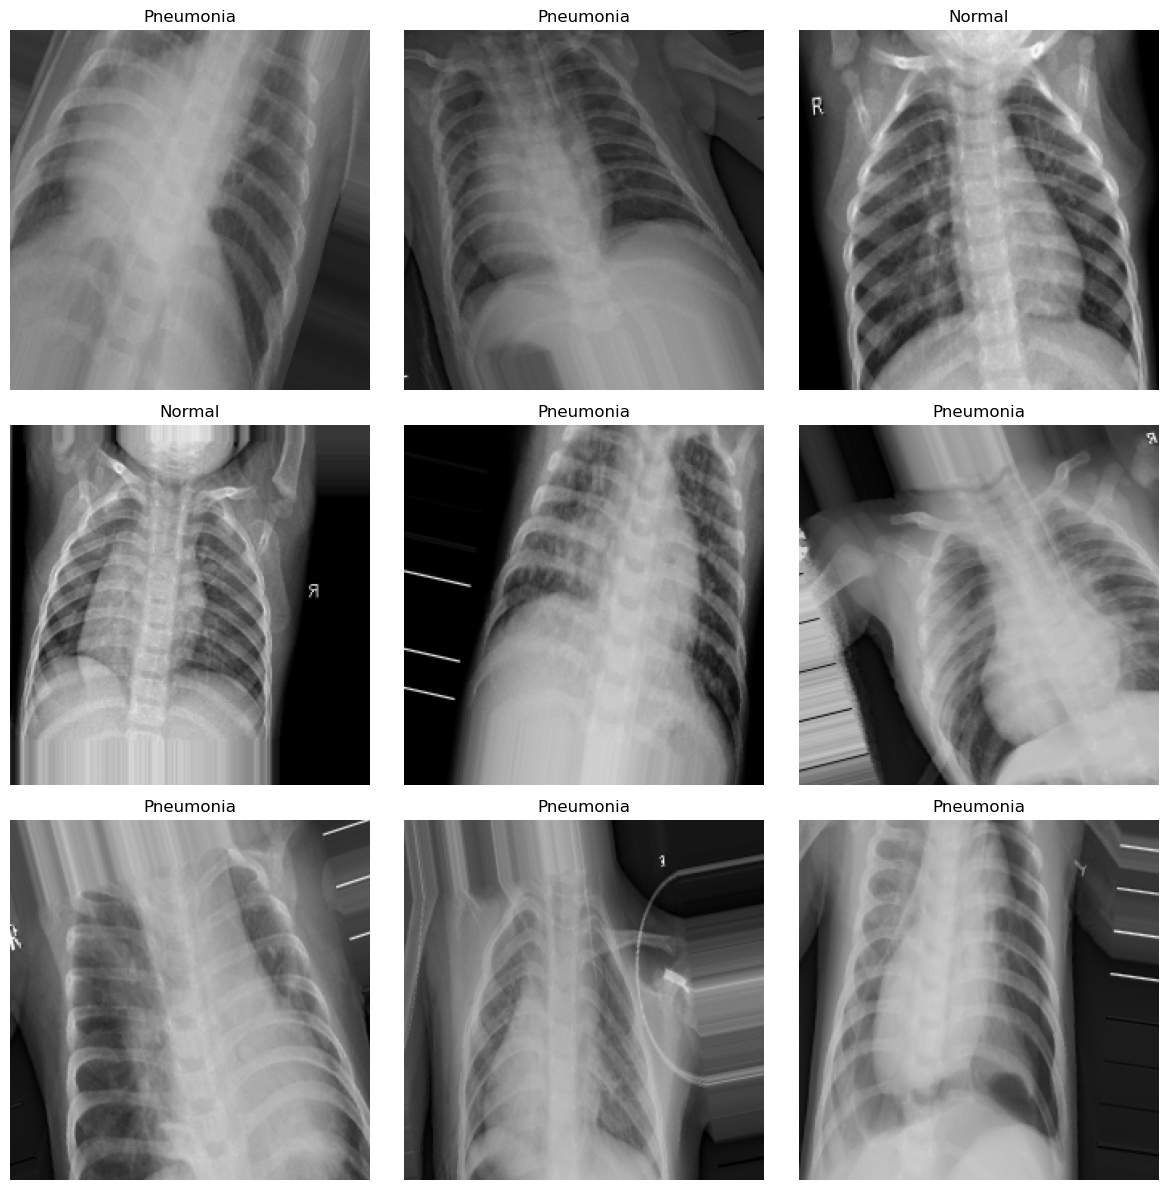

In [10]:
# Visualize augmented images
def visualize_augmentations():
    x, y = next(train_generator)
    plt.figure(figsize=(12, 12))
    
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(x[i])
        plt.title('Pneumonia' if y[i] > 0.5 else 'Normal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

### Step 3: Model Selection and Development

In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input


In [12]:
def create_model(base_model_name, input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    # Define input tensor
    inputs = Input(shape=input_shape)
    
    # Create base model
    if base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    elif base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    elif base_model_name == 'inceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    else:
        raise ValueError("Model name not recognized")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

In [13]:
# Create models
vgg_model = create_model('vgg16')
resnet_model = create_model('resnet50')
inceptionV3_model = create_model('inceptionV3')

2025-04-03 13:10:53.079362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-04-03 13:10:53.079393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-03 13:10:53.079397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-03 13:10:53.079415: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 13:10:53.079425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
print("VGG16 Model Summary:")
vgg_model.summary()

VGG16 Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,043,137 (57.39 MB)

 Trainable params: 328,449 (1.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Step 4: Model Training

In [15]:
# Define callbacks
def get_callbacks(model_name):
    checkpoint = ModelCheckpoint(
        f'best_{model_name}.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
    
    return [checkpoint, early_stopping, reduce_lr]

In [16]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

In [17]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size


In [18]:
# Train VGG16 model
print("Training VGG16 model...")
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=get_callbacks('vgg16'),
    class_weight=class_weight_dict
)


Training VGG16 model...


/Users/bhushannimje/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2025-04-03 13:10:57.088435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6720 - loss: 0.6138 - precision: 0.8443 - recall: 0.6794
Epoch 1: val_loss improved from inf to 0.42926, saving model to best_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 55s 330ms/step - accuracy: 0.6726 - loss: 0.6130 - precision: 0.8447 - recall: 0.6800 - val_accuracy: 0.7500 - val_loss: 0.4293 - val_precision: 0.7000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8665 - loss: 0.3433 - precision: 0.9554 - recall: 0.8596
Epoch 2: val_loss improved from 0.42926 to 0.36138, saving model to best_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.8666 - loss: 0.3433 - precision: 0.9554 - recall: 0.8596 - val_accuracy: 0.7500 - val_loss: 0.3614 - val_precision: 0.7000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8630 - loss: 0.3279 - precision: 0.9587 - recall: 0.8532
Epoch 3: val_loss improved from 0.36138 to 0.34037, saving model to best_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.8630 - loss: 0.3280 - precision: 0.9587 - recall: 0.8533 - val_accuracy: 0.8750 - val_loss: 0.3404 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8708 - loss: 0.3026 - precision: 0.9600 - recall: 0.8615
Epoch 4: val_loss did not improve from 0.34037
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.8709 - loss: 0.3026 - precision: 0.9600 - recall: 0.8616 - val_accuracy: 0.7500 - val_loss: 0.4532 - val_precision: 0.6667 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.8793 - loss: 0.3177 - precision: 0.9557 - recall: 0.8774
Epoch 5: val_loss did not improve from 0.34037
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.8794 - loss: 0.3175 - precision: 0.9558 - recall: 0.8774 - val_accuracy: 0.7500 - val_loss: 0.3540 - val_precision: 0.7000 - val_recall: 0.8750 - 

163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.8910 - loss: 0.2552 - precision: 0.9665 - recall: 0.8855 - val_accuracy: 0.7500 - val_loss: 0.3322 - val_precision: 0.7000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9092 - loss: 0.2153 - precision: 0.9737 - recall: 0.9038
Epoch 8: val_loss improved from 0.33216 to 0.29787, saving model to best_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 321ms/step - accuracy: 0.9092 - loss: 0.2154 - precision: 0.9736 - recall: 0.9038 - val_accuracy: 0.8125 - val_loss: 0.2979 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9011 - loss: 0.2463 - precision: 0.9699 - recall: 0.8968
Epoch 9: val_loss improved from 0.29787 to 0.27284, saving model to best_vgg16.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.9011 - loss: 0.2462 - precision: 0.9699 - recall: 0.8969 - val_accuracy: 0.8750 - val_loss: 0.2728 - val_precision: 0.8750 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9125 - loss: 0.2154 - precision: 0.9785 - recall: 0.9018
Epoch 10: val_loss did not improve from 0.27284
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.9125 - loss: 0.2154 - precision: 0.9785 - recall: 0.9018 - val_accuracy: 0.8125 - val_loss: 0.3122 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9107 - loss: 0.2203 - precision: 0.9694 - recall: 0.9088
Epoch 11: val_loss did not improve from 0.27284
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.9107 - loss: 0.2203 - precision: 0.9694 - recall: 0.9087 - val_accuracy: 0.7500 - val_loss: 0.4062 - val_precision: 0.6667 - val_recall: 1.000

163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 317ms/step - accuracy: 0.9254 - loss: 0.1914 - precision: 0.9741 - recall: 0.9248 - val_accuracy: 0.9375 - val_loss: 0.2703 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9199 - loss: 0.1934 - precision: 0.9774 - recall: 0.9138
Epoch 15: val_loss did not improve from 0.27034
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 316ms/step - accuracy: 0.9199 - loss: 0.1934 - precision: 0.9774 - recall: 0.9138 - val_accuracy: 0.8125 - val_loss: 0.3012 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 16/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9207 - loss: 0.1928 - precision: 0.9785 - recall: 0.9145
Epoch 16: val_loss did not improve from 0.27034
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 315ms/step - accuracy: 0.9207 - loss: 0.1929 - precision: 0.9785 - recall: 0.9145 - val_accuracy: 0.8125 - val_loss: 0.2971 - val_precision: 0.7778 - val_recall: 0.875

In [19]:
# Train ResNet50 model
print("Training ResNet50 model...")
resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=get_callbacks('resnet50'),
    class_weight=class_weight_dict
)

Training ResNet50 model...
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5055 - loss: 1.5731 - precision_1: 0.7429 - recall_1: 0.5024
Epoch 1: val_loss improved from inf to 0.70606, saving model to best_resnet50.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 335ms/step - accuracy: 0.5055 - loss: 1.5732 - precision_1: 0.7430 - recall_1: 0.5024 - val_accuracy: 0.5000 - val_loss: 0.7061 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5110 - loss: 1.5306 - precision_1: 0.7442 - recall_1: 0.5070
Epoch 2: val_loss improved from 0.70606 to 0.65878, saving model to best_resnet50.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.5110 - loss: 1.5302 - precision_1: 0.7443 - recall_1: 0.5070 - val_accuracy: 0.6250 - val_loss: 0.6588 - val_precision_1: 0.5833 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5202 - loss: 1.3878 - precision_1: 0.7555 - recall_1: 0.5270
Epoch 3: val_loss did not improve from 0.65878
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.5202 - loss: 1.3874 - precision_1: 0.7555 - recall_1: 0.5269 - val_accuracy: 0.5000 - val_loss: 0.7788 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.5276 - loss: 1.1582 - precision_1: 0.7589 - recall_1: 0.5291
Epoch 4: val_loss did not improve from 0.65878
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.5276 - loss: 1.1576 - precision_1: 0.7589 - recall_1: 0.5290 - val_accuracy: 0.5625 - val_loss: 0.6653 - val_precision_1: 

163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.5746 - loss: 0.8356 - precision_1: 0.7968 - recall_1: 0.5714 - val_accuracy: 0.6250 - val_loss: 0.6069 - val_precision_1: 0.5833 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6213 - loss: 0.7158 - precision_1: 0.8236 - recall_1: 0.6245
Epoch 6: val_loss improved from 0.60691 to 0.57274, saving model to best_resnet50.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.6214 - loss: 0.7156 - precision_1: 0.8237 - recall_1: 0.6246 - val_accuracy: 0.7500 - val_loss: 0.5727 - val_precision_1: 0.7500 - val_recall_1: 0.7500 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6740 - loss: 0.6255 - precision_1: 0.8593 - recall_1: 0.6743
Epoch 7: val_loss improved from 0.57274 to 0.54688, saving model to best_resnet50.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.6740 - loss: 0.6254 - precision_1: 0.8594 - recall_1: 0.6744 - val_accuracy: 0.8125 - val_loss: 0.5469 - val_precision_1: 0.7778 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.7071 - loss: 0.5828 - precision_1: 0.8760 - recall_1: 0.7146
Epoch 8: val_loss did not improve from 0.54688
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 328ms/step - accuracy: 0.7072 - loss: 0.5828 - precision_1: 0.8760 - recall_1: 0.7146 - val_accuracy: 0.6250 - val_loss: 0.5639 - val_precision_1: 0.5833 - val_recall_1: 0.8750 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7284 - loss: 0.5563 - precision_1: 0.8829 - recall_1: 0.7343
Epoch 9: val_loss did not improve from 0.54688
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 323ms/step - accuracy: 0.7284 - loss: 0.5563 - precision_1: 0.8829 - recall_1: 0.7343 - val_accuracy: 0.8125 - val_loss: 0.5496 - val_precision_1: 

163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.7705 - loss: 0.5277 - precision_1: 0.8925 - recall_1: 0.7883 - val_accuracy: 0.6875 - val_loss: 0.5405 - val_precision_1: 0.6364 - val_recall_1: 0.8750 - learning_rate: 2.0000e-04
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7760 - loss: 0.4961 - precision_1: 0.9158 - recall_1: 0.7673
Epoch 14: val_loss did not improve from 0.54050
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.7760 - loss: 0.4962 - precision_1: 0.9157 - recall_1: 0.7673 - val_accuracy: 0.6250 - val_loss: 0.5776 - val_precision_1: 0.5833 - val_recall_1: 0.8750 - learning_rate: 2.0000e-04
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7811 - loss: 0.5077 - precision_1: 0.9098 - recall_1: 0.7836
Epoch 15: val_loss did not improve from 0.54050
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.7811 - loss: 0.5077 - precision_1: 0.9098 - recall_1: 0.7835 - val_accuracy: 0.6250 - val_loss: 0.6064 - val_p

163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.7811 - loss: 0.4977 - precision_1: 0.9035 - recall_1: 0.7925 - val_accuracy: 0.7500 - val_loss: 0.5285 - val_precision_1: 0.7000 - val_recall_1: 0.8750 - learning_rate: 2.0000e-04
Epoch 18/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7636 - loss: 0.5138 - precision_1: 0.9094 - recall_1: 0.7608
Epoch 18: val_loss did not improve from 0.52849
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.7636 - loss: 0.5138 - precision_1: 0.9094 - recall_1: 0.7609 - val_accuracy: 0.6250 - val_loss: 0.5567 - val_precision_1: 0.5833 - val_recall_1: 0.8750 - learning_rate: 2.0000e-04
Epoch 19/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7473 - loss: 0.5298 - precision_1: 0.8950 - recall_1: 0.7406
Epoch 19: val_loss did not improve from 0.52849
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 325ms/step - accuracy: 0.7474 - loss: 0.5296 - precision_1: 0.8951 - recall_1: 0.7408 - val_accuracy: 0.6250 - val_loss: 0.5914 - val_p

In [25]:
# Train IceptionV3 model
print("Training InceptionV3 model...")
inceptionV3_history = inceptionV3_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=get_callbacks('inceptionV3'),
    class_weight=class_weight_dict
)

Training IceptionV3 model...
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9014 - loss: 0.2508 - precision_2: 0.9713 - recall_2: 0.8941
Epoch 1: val_loss improved from inf to 0.32879, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 324ms/step - accuracy: 0.9014 - loss: 0.2508 - precision_2: 0.9713 - recall_2: 0.8941 - val_accuracy: 0.9375 - val_loss: 0.3288 - val_precision_2: 0.8889 - val_recall_2: 1.0000 - learning_rate: 2.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9043 - loss: 0.2243 - precision_2: 0.9715 - recall_2: 0.8988
Epoch 2: val_loss did not improve from 0.32879
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 314ms/step - accuracy: 0.9043 - loss: 0.2244 - precision_2: 0.9715 - recall_2: 0.8987 - val_accuracy: 0.8125 - val_loss: 0.3504 - val_precision_2: 0.7273 - val_recall_2: 1.0000 - learning_rate: 2.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9096 - loss: 0.2349 - precision_2: 0.9677 - recall_2: 0.9083
Epoch 3: val_loss improved from 0.32879 to 0.30677, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.9095 - loss: 0.2348 - precision_2: 0.9677 - recall_2: 0.9083 - val_accuracy: 0.8750 - val_loss: 0.3068 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 2.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8889 - loss: 0.2430 - precision_2: 0.9647 - recall_2: 0.8821
Epoch 4: val_loss improved from 0.30677 to 0.28965, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.8889 - loss: 0.2430 - precision_2: 0.9647 - recall_2: 0.8822 - val_accuracy: 0.8750 - val_loss: 0.2897 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 2.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9010 - loss: 0.2331 - precision_2: 0.9711 - recall_2: 0.8907
Epoch 5: val_loss improved from 0.28965 to 0.28421, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9010 - loss: 0.2331 - precision_2: 0.9711 - recall_2: 0.8908 - val_accuracy: 0.8750 - val_loss: 0.2842 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 2.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9219 - loss: 0.2048 - precision_2: 0.9750 - recall_2: 0.9186
Epoch 6: val_loss did not improve from 0.28421
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 318ms/step - accuracy: 0.9218 - loss: 0.2049 - precision_2: 0.9750 - recall_2: 0.9186 - val_accuracy: 0.8750 - val_loss: 0.2846 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 2.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9125 - loss: 0.2120 - precision_2: 0.9716 - recall_2: 0.9088
Epoch 7: val_loss improved from 0.28421 to 0.28364, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9125 - loss: 0.2120 - precision_2: 0.9716 - recall_2: 0.9088 - val_accuracy: 0.8750 - val_loss: 0.2836 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 2.0000e-04
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9071 - loss: 0.2272 - precision_2: 0.9692 - recall_2: 0.9046
Epoch 8: val_loss did not improve from 0.28364
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.9071 - loss: 0.2271 - precision_2: 0.9692 - recall_2: 0.9046 - val_accuracy: 0.8125 - val_loss: 0.3748 - val_precision_2: 0.7273 - val_recall_2: 1.0000 - learning_rate: 2.0000e-04
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9134 - loss: 0.2154 - precision_2: 0.9722 - recall_2: 0.9097
Epoch 9: val_loss did not improve from 0.28364
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 321ms/step - accuracy: 0.9134 - loss: 0.2154 - precision_2: 0.9722 - recall_2: 0.9097 - val_accuracy: 0.8750 - val_loss: 0.3161 - val_preci

163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.9268 - loss: 0.1884 - precision_2: 0.9793 - recall_2: 0.9209 - val_accuracy: 0.8750 - val_loss: 0.2787 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 4.0000e-05
Epoch 16/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9151 - loss: 0.2042 - precision_2: 0.9780 - recall_2: 0.9071
Epoch 16: val_loss improved from 0.27875 to 0.27697, saving model to best_inceptionV3.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 322ms/step - accuracy: 0.9151 - loss: 0.2042 - precision_2: 0.9779 - recall_2: 0.9071 - val_accuracy: 0.8750 - val_loss: 0.2770 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 4.0000e-05
Epoch 17/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9048 - loss: 0.2227 - precision_2: 0.9744 - recall_2: 0.8951
Epoch 17: val_loss did not improve from 0.27697
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 320ms/step - accuracy: 0.9048 - loss: 0.2226 - precision_2: 0.9744 - recall_2: 0.8952 - val_accuracy: 0.8750 - val_loss: 0.2856 - val_precision_2: 0.8750 - val_recall_2: 0.8750 - learning_rate: 4.0000e-05
Epoch 18/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9208 - loss: 0.1948 - precision_2: 0.9740 - recall_2: 0.9182
Epoch 18: val_loss did not improve from 0.27697
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 319ms/step - accuracy: 0.9208 - loss: 0.1948 - precision_2: 0.9741 - recall_2: 0.9182 - val_accuracy: 0.9375 - val_loss: 0.2966 - val_p

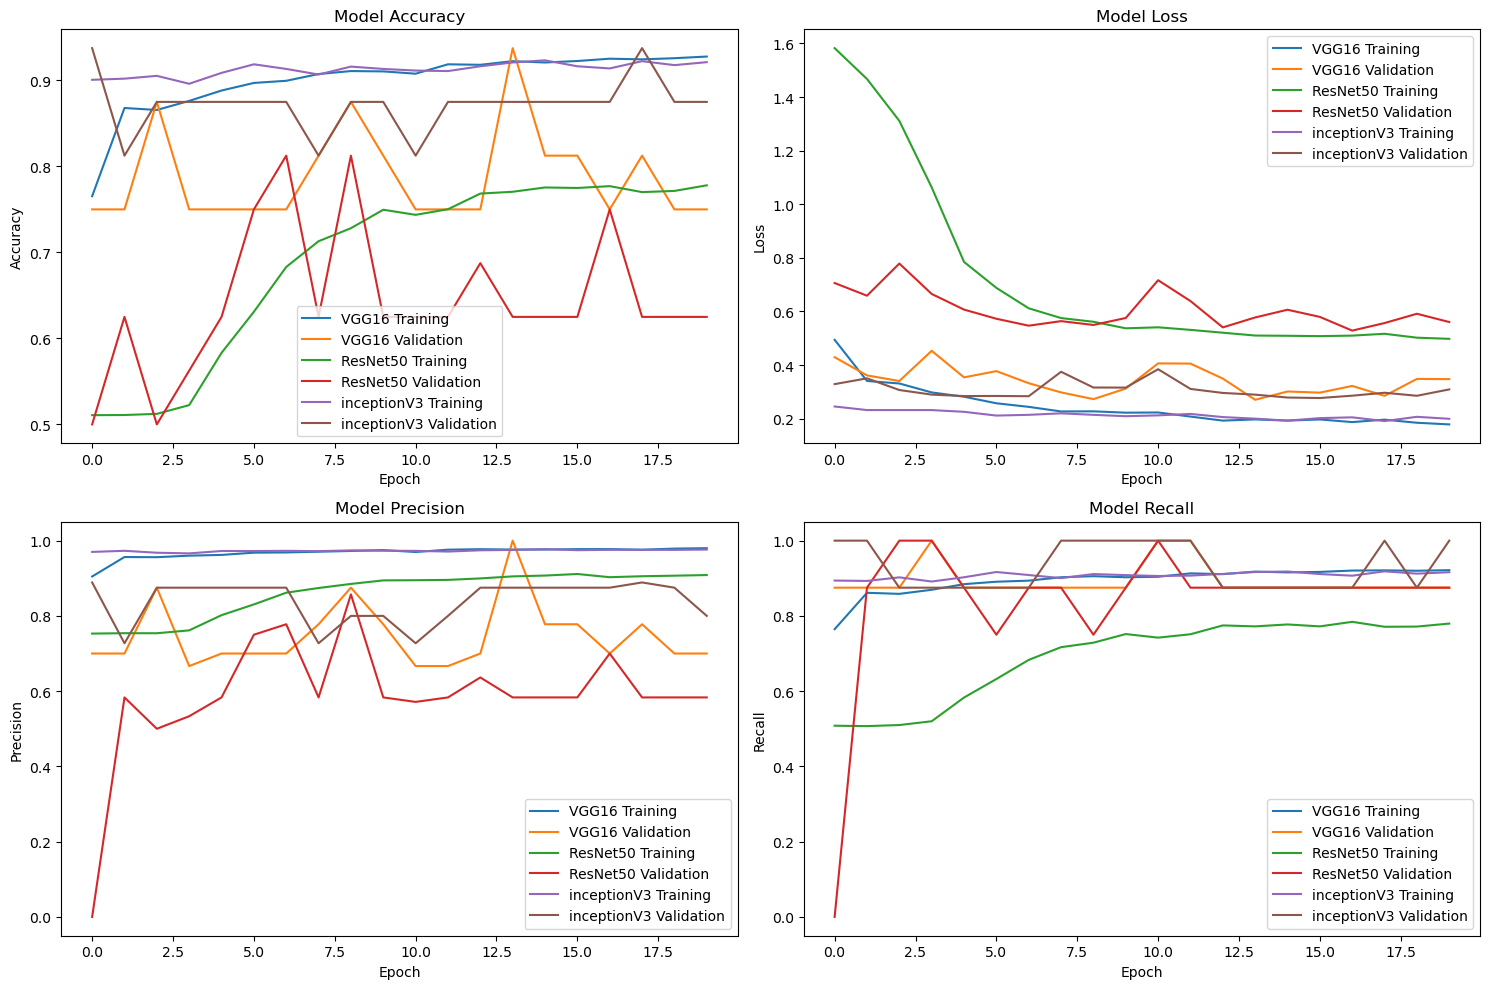

In [29]:
# Function to plot training history
def plot_history(histories, names):
    plt.figure(figsize=(15, 10))
    
    # Plot accuracy
    plt.subplot(2, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=f'{name} Training')
        plt.plot(history.history['val_accuracy'], label=f'{name} Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot loss
    plt.subplot(2, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=f'{name} Training')
        plt.plot(history.history['val_loss'], label=f'{name} Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot precision
    plt.subplot(2, 2, 3)
    for history, name in zip(histories, names):
        # Check for different possible key names
        precision_key = next((k for k in history.history.keys() if 'precision' in k and 'val' not in k), None)
        val_precision_key = next((k for k in history.history.keys() if 'precision' in k and 'val' in k), None)
        
        if precision_key:
            plt.plot(history.history[precision_key], label=f'{name} Training')
        if val_precision_key:
            plt.plot(history.history[val_precision_key], label=f'{name} Validation')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Plot recall
    plt.subplot(2, 2, 4)
    for history, name in zip(histories, names):
        # Check for different possible key names
        recall_key = next((k for k in history.history.keys() if 'recall' in k and 'val' not in k), None)
        val_recall_key = next((k for k in history.history.keys() if 'recall' in k and 'val' in k), None)
        
        if recall_key:
            plt.plot(history.history[recall_key], label=f'{name} Training')
        if val_recall_key:
            plt.plot(history.history[val_recall_key], label=f'{name} Validation')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(
    [vgg_history, resnet_history, inceptionV3_history],
    ['VGG16', 'ResNet50', 'InceptionV3']
) 

### Step 5: Model Evaluation and Selection

In [30]:
# Load best models
vgg_model = tf.keras.models.load_model('best_vgg16.h5')
resnet_model = tf.keras.models.load_model('best_resnet50.h5')
inceptionV3_model = tf.keras.models.load_model('best_inceptionV3.h5')


In [34]:
models = [vgg_model, resnet_model, inceptionV3_model]
model_names = ['VGG16', 'ResNet50', 'InceptionV3']

In [35]:
# Evaluate models on test set
for model, name in zip(models, model_names):
    test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-10)
    
    print(f"\n{name} Test Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.8922 - loss: 0.2625 - precision: 0.6047 - recall: 0.4918

VGG16 Test Results:
Loss: 0.4567
Accuracy: 0.8029
Precision: 0.9652
Recall: 0.7103
F1 Score: 0.8183
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8277 - loss: 0.4514 - precision_1: 0.5418 - recall_1: 0.4168

ResNet50 Test Results:
Loss: 0.6166
Accuracy: 0.7179
Precision: 0.9180
Recall: 0.6026
F1 Score: 0.7276
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.8637 - loss: 0.3434 - precision_2: 0.5276 - recall_2: 0.5757

InceptionV3 Test Results:
Loss: 0.3712
Accuracy: 0.8510
Precision: 0.9068
Recall: 0.8487
F1 Score: 0.8768


In [ ]:
# Generate predictions for confusion matrix
def evaluate_model(model, generator, name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    
    # Generate classification report
    print(f"\nClassification Report - {name}:")
    print(classification_report(true_classes, predicted_classes, 
                               target_names=['Normal', 'Pneumonia']))
    
    # ROC curve
    fpr, tpr, _ = roc_curve(true_classes, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return roc_auc

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step


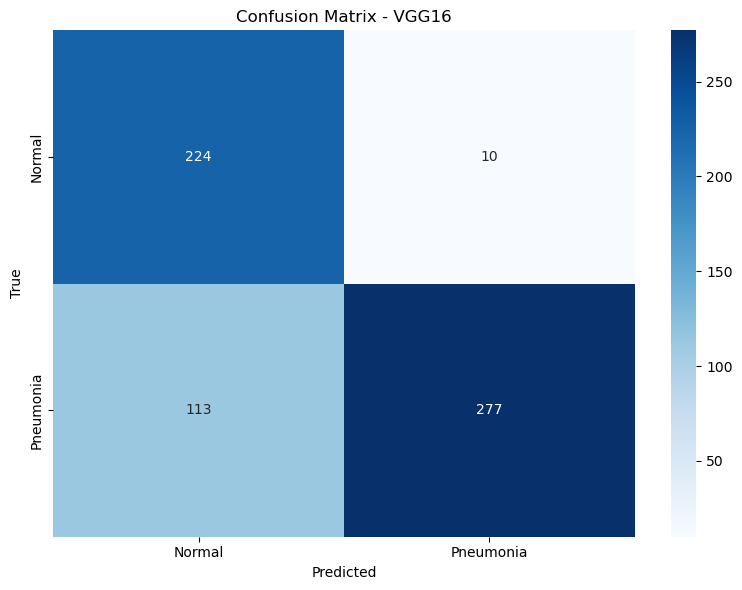


Classification Report - VGG16:
              precision    recall  f1-score   support

      Normal       0.66      0.96      0.78       234
   Pneumonia       0.97      0.71      0.82       390

    accuracy                           0.80       624
   macro avg       0.81      0.83      0.80       624
weighted avg       0.85      0.80      0.81       624



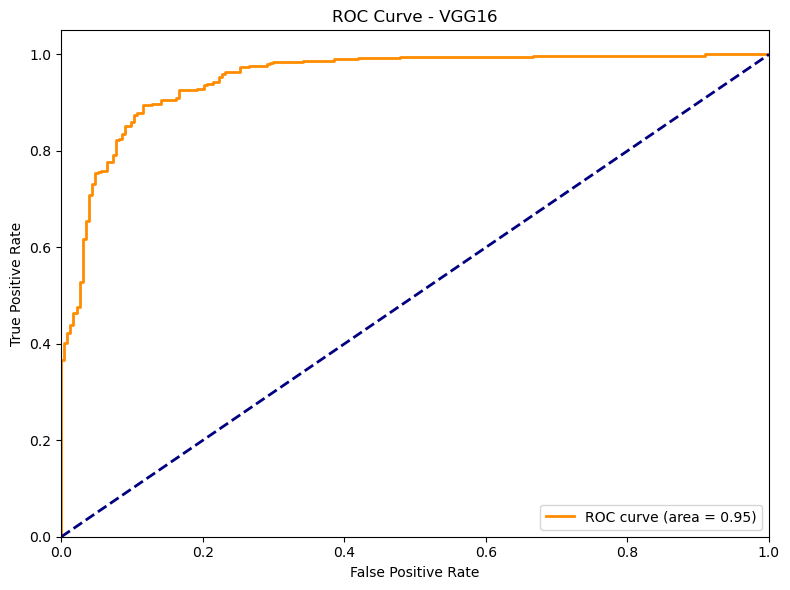

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 279ms/step


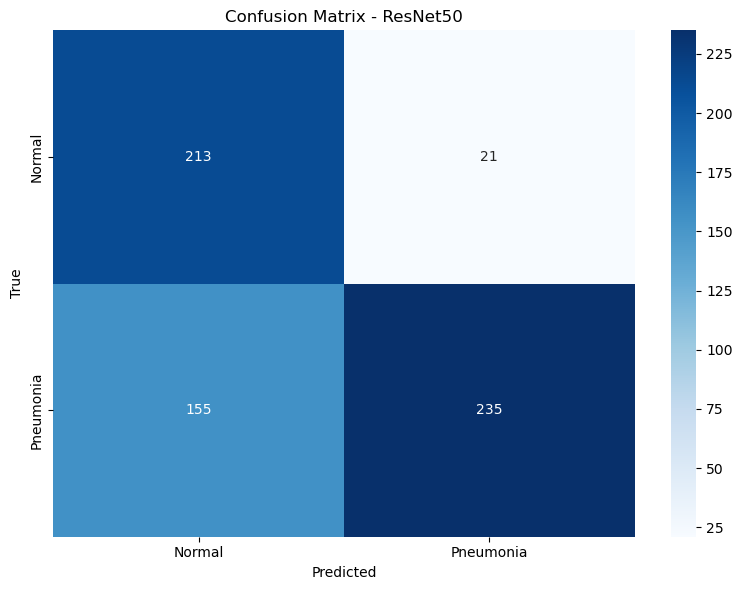


Classification Report - ResNet50:
              precision    recall  f1-score   support

      Normal       0.58      0.91      0.71       234
   Pneumonia       0.92      0.60      0.73       390

    accuracy                           0.72       624
   macro avg       0.75      0.76      0.72       624
weighted avg       0.79      0.72      0.72       624



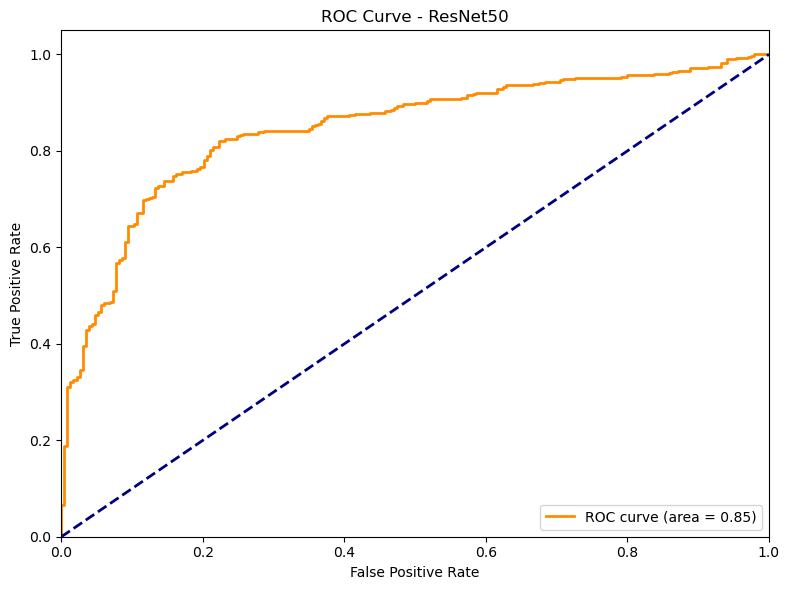

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 303ms/step


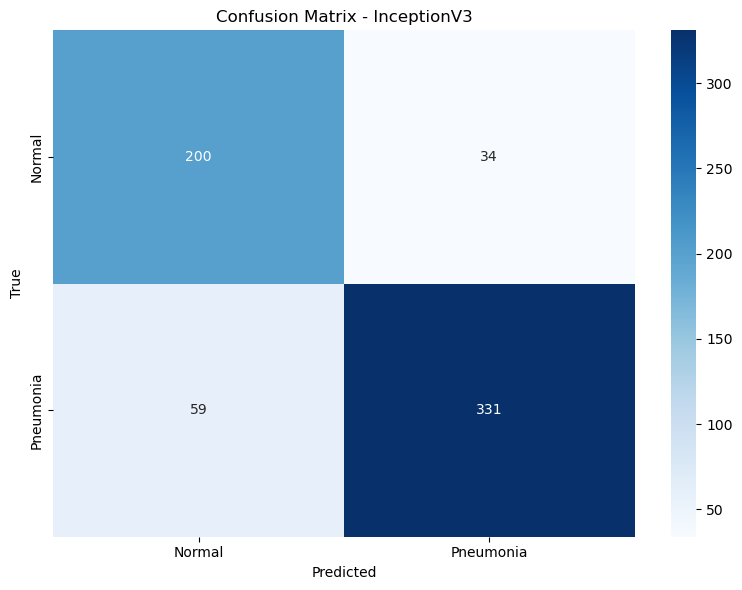


Classification Report - InceptionV3:
              precision    recall  f1-score   support

      Normal       0.77      0.85      0.81       234
   Pneumonia       0.91      0.85      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.86      0.85      0.85       624



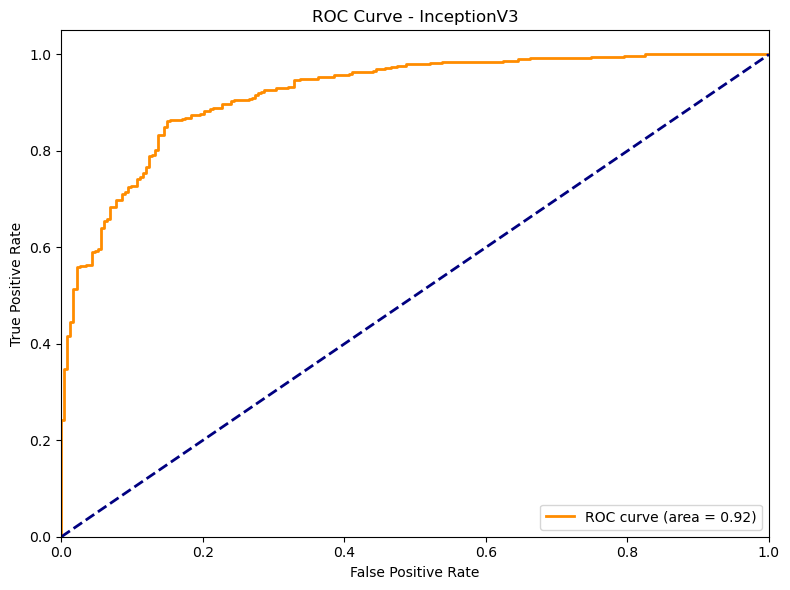


Best model based on AUC: VGG16


In [38]:
# Evaluate all models
auc_scores = []
for model, name in zip(models, model_names):
    auc_score = evaluate_model(model, test_generator, name)
    auc_scores.append(auc_score)

# Select the best model based on AUC
best_model_index = np.argmax(auc_scores)
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

print(f"\nBest model based on AUC: {best_model_name}")
best_model.save('best_pneumonia_model.h5')

### Step 6: Model Interpretability

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [41]:
# Load best model
model = load_model('best_pneumonia_model.h5')

In [71]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # This is the gradient of the output neuron with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Get the first sample's conv output (we're likely processing one image)
    last_conv_layer_output = last_conv_layer_output[0]
    
    # Create a weighted combination of feature maps using the pooled gradients
    # First multiply each channel's gradient importance by the whole feature map
    weighted_features = tf.einsum('ijk,k->ijk', last_conv_layer_output, pooled_grads)
    
    # Then sum across all channels to get the final heatmap
    heatmap = tf.reduce_sum(weighted_features, axis=-1)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

In [72]:
# Function to load and preprocess image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

In [73]:
# Function to overlay heatmap on image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # Ensure img is RGB if it's grayscale
    if img.shape[-1] == 1:
        img = np.concatenate([img, img, img], axis=-1)
    
    # Resize the heatmap to match original image dimensions
    heatmap_resized = tf.image.resize(
        tf.expand_dims(heatmap, axis=-1),  # Add channel dimension
        (img.shape[0], img.shape[1])
    ).numpy()
    
    # Apply a colormap to the heatmap
    heatmap_resized = np.squeeze(heatmap_resized)  # Remove channel dimension again
    heatmap_colored = np.uint8(plt.cm.jet(heatmap_resized)[:, :, :3] * 255)
    
    # Superimpose the heatmap on the original image
    superimposed_img = np.uint8(img * (1-alpha) + heatmap_colored * alpha)
    
    # Display the results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img / 255.0)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_colored)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img / 255.0)
    plt.title("Superimposed")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return superimposed_img

In [74]:
# Find last convolutional layer
last_conv_layer_name = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer_name = layer.name
        break

print(f"Last convolutional layer: {last_conv_layer_name}")


Last convolutional layer: block5_conv3


In [75]:
# Apply Grad-CAM to some test images
test_normal_path = os.path.join(test_dir, "NORMAL", os.listdir(os.path.join(test_dir, "NORMAL"))[0])
test_pneumonia_path = os.path.join(test_dir, "PNEUMONIA", os.listdir(os.path.join(test_dir, "PNEUMONIA"))[0])


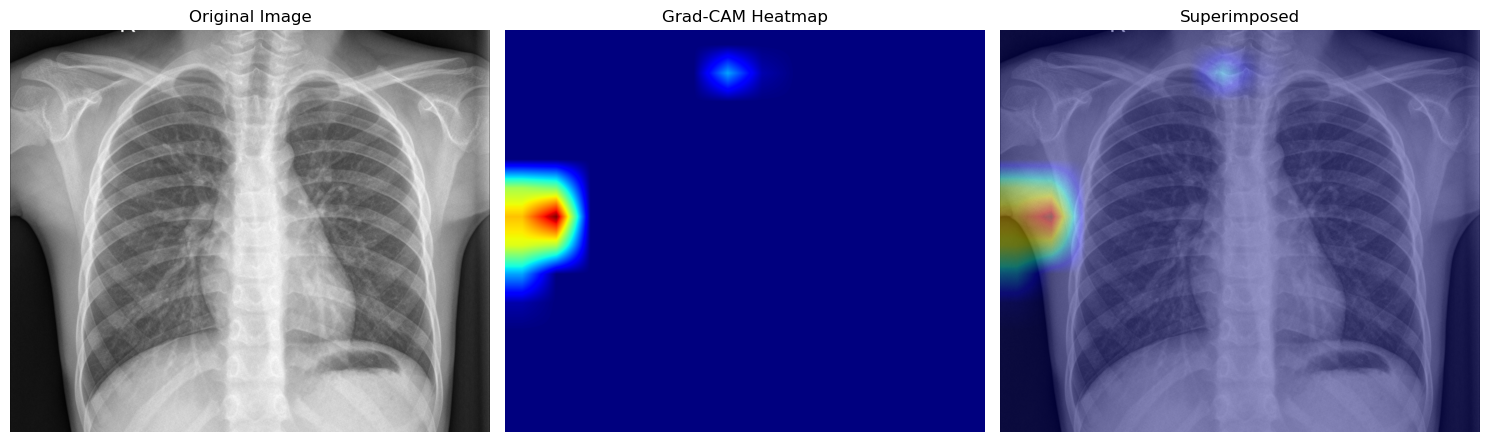

array([[[  0,   0,  51],
        [ 15,  15,  66],
        [ 13,  13,  64],
        ...,
        [ 76,  76, 127],
        [ 78,  78, 129],
        [  0,   0,  50]],

       [[  0,   0,  51],
        [ 15,  15,  66],
        [ 13,  13,  64],
        ...,
        [ 78,  78, 129],
        [ 81,  81, 131],
        [  1,   1,  52]],

       [[  0,   0,  50],
        [ 15,  15,  66],
        [ 13,  13,  64],
        ...,
        [ 79,  79, 130],
        [ 82,  82, 133],
        [  2,   2,  53]],

       ...,

       [[  0,   0,  51],
        [ 11,  11,  62],
        [ 13,  13,  64],
        ...,
        [ 33,  33,  84],
        [ 31,  31,  82],
        [  1,   1,  52]],

       [[  0,   0,  51],
        [ 11,  11,  62],
        [ 12,  12,  63],
        ...,
        [ 33,  33,  83],
        [ 31,  31,  82],
        [  1,   1,  52]],

       [[  0,   0,  51],
        [ 11,  11,  62],
        [ 12,  12,  63],
        ...,
        [ 33,  33,  83],
        [ 31,  31,  82],
        [  1,   1,  52]]

In [76]:
# Normal case
img_array = load_and_preprocess_image(test_normal_path)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
save_and_display_gradcam(test_normal_path, heatmap)
